In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pca_tools import pca_scores
from scipy.stats import ttest_ind

In [2]:
%matplotlib inline

In [3]:
pbp = pd.read_csv('play_by_play.csv')
pbp['teamID'] = pbp.offensive_team.astype(str) + pbp.season.astype(str)

pbp = pbp[pbp.teamID != 'nan2010']


In [6]:
# Filter Data 
# Only Passing plays without sacks
play_filter = (pbp.pass_outcome == 'Complete') | (pbp.pass_outcome == 'Incomplete') 
filtered_data = pbp[play_filter & (pbp.accepted_penalty == 0)]

# Only 3rd and medium plays
play_filter = (filtered_data.down == 3) 
mid_filter = (filtered_data.yds_to_go > 2) | (filtered_data.yds_to_go < 7)
filtered_data = filtered_data[play_filter & mid_filter]

teams = filtered_data.groupby('teamID').count()


In [7]:
yd_bins = np.arange(-100, 101, 1)
distributions = np.zeros((teams.index.size, len(yd_bins) - 1))
for i, team in enumerate(teams.index[:-1]):
        
    single_team = filtered_data[(filtered_data.teamID == team)]
    # Yards ball was in air
    #print(team)
    #print(team)
    #print(single_team.air_yds)
    all_plays = plt.hist(single_team.air_yds.values, bins=yd_bins)
    total_plays = single_team.play_attempted.count()
    
    # Normalized histogram for each team
    distributions[i, :] = all_plays[0] / total_plays
    plt.close()

In [8]:
pca = PCA()
pca.fit(distributions)
mean_distribution = np.mean(distributions, axis=0)
n_components = len(yd_bins) - 1

In [ ]:
plt.close()

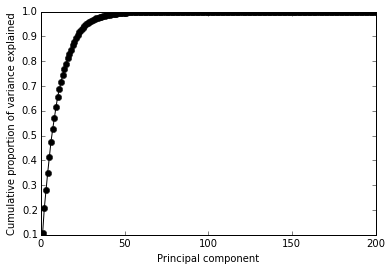

In [9]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(1, n_components + 1, 1)
plt.plot(x, cumulative_variance, 'ko-')

plt.xlabel('Principal component')
plt.ylabel('Cumulative proportion of variance explained')

plt.savefig('pca_variance.pdf')

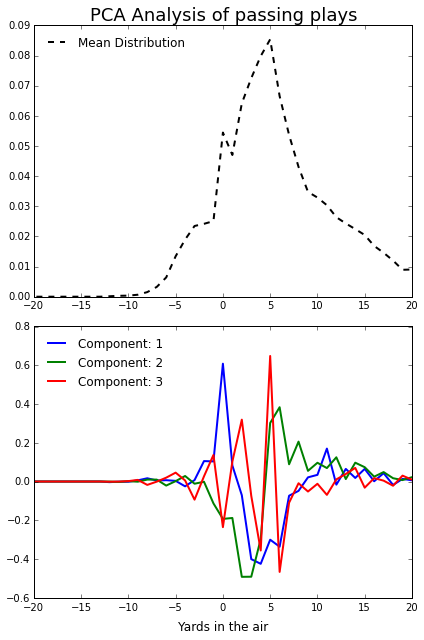

In [31]:
n = 3

plt.figure(figsize=(6, 9))

plt.subplot(211)
plt.title('PCA Analysis of passing plays', fontsize=18)
plt.plot(yd_bins[:-1], mean_distribution, 'k--',linewidth=2, label='Mean Distribution')
plt.xlim([-20, 20])
plt.yticks(np.arange(0, .1, 0.01))
plt.legend(frameon=False, loc=2)
plt.subplot(212)
for i in range(n):
    plt.plot(yd_bins[:-1], pca.components_[i], label='Component: {}'.format(i + 1), linewidth=2)
plt.xlim([-20, 20])
plt.legend(frameon=False,loc=2)
plt.xlabel('Yards in the air', fontsize=12, labelpad=8)
plt.tight_layout()

plt.savefig('pca_components.pdf')

In [11]:
from pca_tools import pca_scores

In [12]:
scores = pca_scores(distributions, pca.components_[0:20, :])

In [13]:
from scipy.stats import norm, linregress


In [14]:
team_stats = pd.read_csv('team_stats.csv', index_col=0)
team_stats.sort_index(inplace=True)


In [16]:
for n in range(10):

    m, b, r_value, p_value, std_err = linregress(scores[n, :], team_stats.third_mid_rate)
    x0 = min(scores[n, :])
    xf = max(scores[n, :])
    x = np.linspace(x0, xf,  100)
    y = m * x + b
    print('Component: {}, P value: {}'.format(n + 1, p_value))

Component: 1, P value: 0.414056549911
Component: 2, P value: 0.416446391088
Component: 3, P value: 0.815531344528
Component: 4, P value: 0.151110354743
Component: 5, P value: 0.0020972444985
Component: 6, P value: 0.158771839327
Component: 7, P value: 0.000650608003196
Component: 8, P value: 0.632234594963
Component: 9, P value: 0.0398265903489
Component: 10, P value: 0.00920426855304


(0.19141246911159723, 0.0020972444984972923)


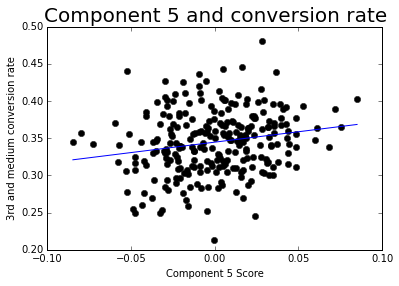

In [29]:
n = 4
plt.plot(scores[n, :], team_stats.third_mid_rate.values, 'ko')
m, b, r_value, p_value, std_err = linregress(scores[n, :], team_stats.third_mid_rate)
x0 = min(scores[n, :])
xf = max(scores[n, :])
x = np.linspace(x0, xf,  100)
y = m * x + b
plt.plot(x, y)
plt.xlabel('Component {} Score'.format(n+1))
plt.ylabel('3rd and medium conversion rate')
plt.title('Component {} and conversion rate'.format(n+1), fontsize=20)

plt.savefig('linear_fit{}.pdf'.format(n))
print(r_value, p_value)

(-0.21171469030192269, 0.00065060800319607362)


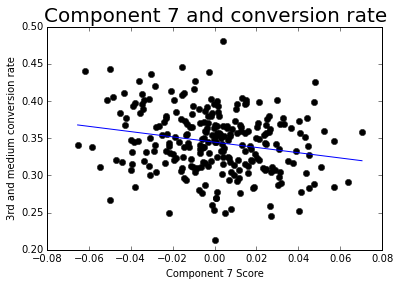

In [28]:
n = 6
plt.plot(scores[n, :], team_stats.third_mid_rate.values, 'ko')
m, b, r_value, p_value, std_err = linregress(scores[n, :], team_stats.third_mid_rate.values)
x0 = min(scores[n, :])
xf = max(scores[n, :])
x = np.linspace(x0, xf,  100)
y = m * x + b
plt.plot(x, y)
plt.xlabel('Component {} Score'.format(n+1))
plt.ylabel('3rd and medium conversion rate')
plt.title('Component {} and conversion rate'.format(n+1), fontsize=20)

plt.savefig('linear_fit{}.pdf'.format(n))
print(r_value, p_value)

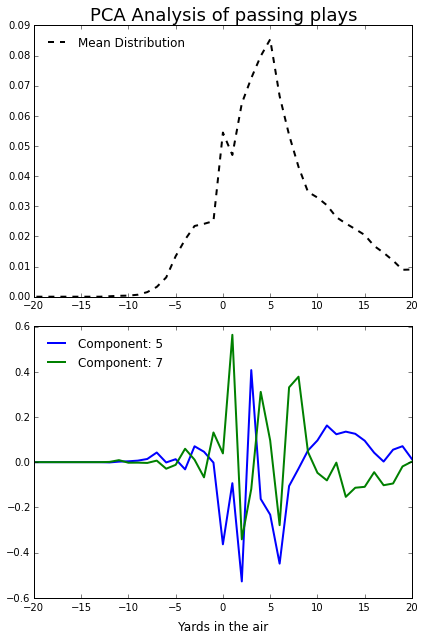

In [30]:
ns = [4, 6]

plt.figure(figsize=(6, 9))

plt.subplot(211)
plt.title('PCA Analysis of passing plays', fontsize=18)
plt.plot(yd_bins[:-1], mean_distribution, 'k--',linewidth=2, label='Mean Distribution')
plt.xlim([-20, 20])
plt.yticks(np.arange(0, .1, 0.01))
plt.legend(frameon=False, loc=2)
plt.subplot(212)
for n in ns:
    plt.plot(yd_bins[:-1], pca.components_[n], label='Component: {}'.format(n + 1), linewidth=2)
plt.xlim([-20, 20])
plt.legend(frameon=False,loc=2)
plt.xlabel('Yards in the air', fontsize=12, labelpad=8)
plt.tight_layout()

plt.savefig('pca_components.pdf')